Postavljanje okruženja

In [1]:
!pip install pandas openpyxl
!pip install arch
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import drive
import seaborn as sns
import warnings
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Diplomski/diplomski/datasets/apple/Apple_historical_data.csv'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 8.9 MB/s eta 0:00:00
Mounted at /content/drive


Postavljanje dataseta:

*   Dataset sadržava vrijednosti za svaki radni dan burze od 2015 do 2020
* Svaki redak sadržava datum i cijenu dionice na taj dan

In [2]:
data = pd.read_csv(file_path)

features_to_shift = [
  "yesterday_price"
]

data['yesterday_price'] = data['Adj_Close']
data[features_to_shift] = data[features_to_shift].shift(1)
data['price_diff'] = data['yesterday_price'] -  data['Adj_Close']

data = data[(data['Date'] >= '2015-01-01') & (data['Date'] <= '2020-01-01')]
features_to_keep = ["Date","Adj_Close", 'yesterday_price', 'price_diff']
data = data[features_to_keep]
data = data.reset_index(drop=True)
data

,Date,Adj_Close,yesterday_price,price_diff
0,2015-01-02,24.435265,24.669943,0.234678
1,2015-01-05,23.746889,24.435265,0.688376
2,2015-01-06,23.749128,23.746889,-0.002239
3,2015-01-07,24.082130,23.749128,-0.333002
4,2015-01-08,25.007435,24.082130,-0.925305
...,...,...,...,...
1253,2019-12-24,69.147995,69.082321,-0.065674
1254,2019-12-26,70.519913,69.147995,-1.371918
1255,2019-12-27,70.493164,70.519913,0.026749
1256,2019-12-30,70.911545,70.493164,-0.418381


Računamo AIC i BIC za različite vrijednosti p i q

Pomaže za odabir optimalne p i q vrijednosti:
*   Akaike Information Criterion (AIC)
*   Bayesian Information Criterion (BIC)


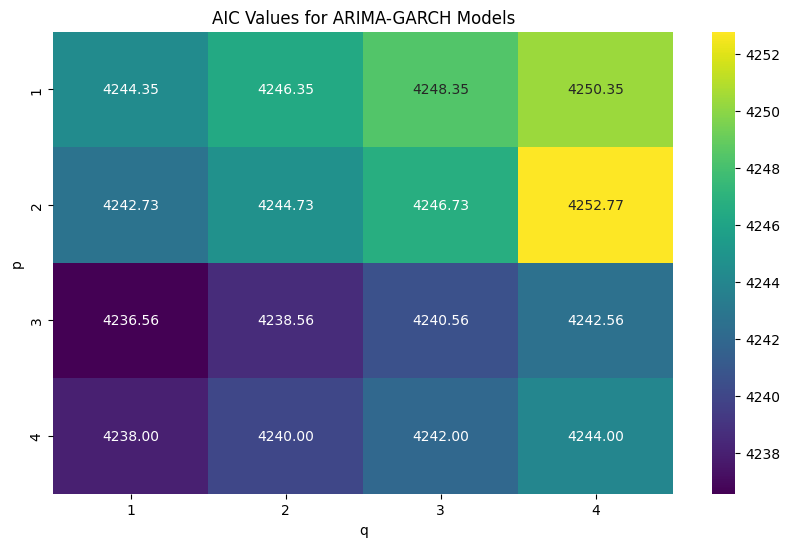

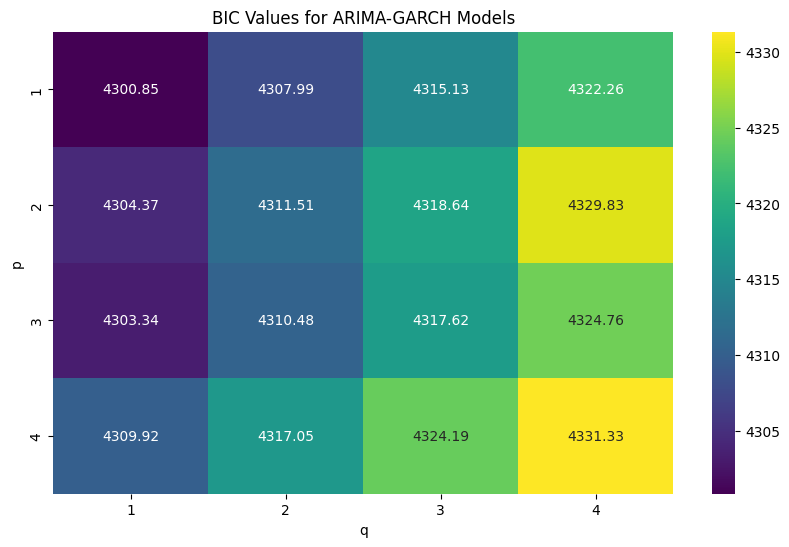

In [3]:
warnings.filterwarnings("ignore")

train_data = data

p_values = range(1, 5)
q_values = range(1, 5)

aic_values = pd.DataFrame(index=p_values, columns=q_values).astype(float)
bic_values = pd.DataFrame(index=p_values, columns=q_values).astype(float)

for p in p_values:
    for q in q_values:
        try:
            # Fit ARIMA model
            arima_model = ARIMA(train_data['Adj_Close'].values, order=(3, 1, 3))
            arima_model_fit = arima_model.fit()

            # Fit GARCH model
            garch_model = arch_model(arima_model_fit.resid, vol='Garch', p=p, q=q)
            garch_model_fit = garch_model.fit(disp='off')

            # Calculate AIC and BIC
            aic_values.loc[p, q] = arima_model_fit.aic + garch_model_fit.aic
            bic_values.loc[p, q] = arima_model_fit.bic + garch_model_fit.bic

        except:
            aic_values.loc[p, q] = np.nan
            bic_values.loc[p, q] = np.nan

# Plot AIC values
plt.figure(figsize=(10, 6))
sns.heatmap(aic_values, cmap='viridis', annot=True, fmt=".2f")
plt.title('AIC Values for ARIMA-GARCH Models')
plt.xlabel('q')
plt.ylabel('p')
plt.show()

# Plot BIC values
plt.figure(figsize=(10, 6))
sns.heatmap(bic_values, cmap='viridis', annot=True, fmt=".2f")
plt.title('BIC Values for ARIMA-GARCH Models')
plt.xlabel('q')
plt.ylabel('p')
plt.show()

# Walk forward validation
Time-series algoritmi rade na način da predviđaju buduću cijenu na temelju prošlih. Ovaj algoritam radi na isti način kao ARIMA, gdje se predviđa cijena na temelju povijesnih cijena. Vrijednosti iz GARCH i ARIMA modela se kombiniraju kako bismo dobili konačnu cijenu. Tu predviđenu cijenu spremamo u polje te ponavljamo isti postupak za idući dan itd...

Na kraju se uspoređuju stvarne cijene i predviđene i računamo:
*   MAE - Mean Absolute Error
*   MSE - Mean Squared Error
*  RMSE - Root Mean Squared Error
*   MAPE - Mean Absolute Percentage Error

In [4]:
#def mean_absolute_percentage_error(actuals, predictions):
#    actuals, predictions = np.array(actuals), np.array(predictions)
#    return np.mean(np.abs((actuals - predictions) / actuals)) * 100
#
#def walk_forward_validation(data, train_size, p, d, q, garch_order):
#    actual_values = []
#    predicted_values = []
#    for i in range(train_size, len(data)):
#        train_data = data.iloc[:i]
#        test_data = data.iloc[i:i+1]
#
#        # Fit ARIMA model
#        arima_model = ARIMA(train_data['Adj_Close'].values, order=(p, d, q))
#        arima_model_fit = arima_model.fit()
#        predicted_mu = arima_model_fit.forecast(steps=1)[0]
#
#        # Fit GARCH model
#        garch_model = arch_model(arima_model_fit.resid, vol='Garch', p=garch_order[0], q=garch_order[1])
#        garch_model_fit = garch_model.fit(disp='off')
#
#        # Forecast
#        predicted_et = garch_model_fit.forecast(horizon=1)
#        predicted_et = predicted_et.mean.iloc[-1, 0]
#
#        # Combine both models' output: yt = mu + et
#        prediction = predicted_mu + predicted_et
#
#        actual_values.append(test_data['Adj_Close'].values[0])
#        predicted_values.append(prediction)
#
#    mae = mean_absolute_error(actual_values, predicted_values)
#    mse = mean_squared_error(actual_values, predicted_values)
#    rmse = np.sqrt(mse)
#    mape = mean_absolute_percentage_error(actual_values, predicted_values)
#
#    return predicted_values, actual_values, mae, mse, rmse, mape

Postavljnaje parametara ARIMA i GARCH modela:
* Pozivamo onda funkciju walk_forward_validation kako bismo dobili previđene cijene

In [5]:
def walk_forward_validation(data, train_size, p, d, q, garch_order):
    actual_values = []
    predicted_values = []
    rmse_values = []
    for i in range(train_size, len(data)):
        train_data = data.iloc[:i]
        test_data = data.iloc[i:i+1]

        # Fit ARIMA model
        arima_model = ARIMA(train_data['Adj_Close'].values, order=(p, d, q))
        arima_model_fit = arima_model.fit()
        predicted_mu = arima_model_fit.forecast(steps=1)[0]

        # Fit GARCH model
        garch_model = arch_model(arima_model_fit.resid, vol='Garch', p=garch_order[0], q=garch_order[1])
        garch_model_fit = garch_model.fit(disp='off')

        # Forecast
        predicted_et = garch_model_fit.forecast(horizon=1)
        predicted_et = predicted_et.mean.iloc[-1, 0]

        # Combine both models' output: yt = mu + et
        prediction = predicted_mu + predicted_et

        actual = test_data['price_diff'].values[0]
        actual_values.append(test_data['price_diff'].values[0])
        prediction = test_data['yesterday_price'].values[0] - prediction
        predicted_values.append(prediction)
        prediction = [prediction]
        actual = [actual]
        mse = mean_squared_error(actual, prediction)
        rmse = np.sqrt(mse)
        rmse_values.append(rmse)

    return predicted_values, actual_values , rmse_values

warnings.filterwarnings("ignore")  # Ignore ARIMA convergence warnings

train_size = int(len(data) * 0.8)

p = 3
d = 1
q = 3
garch_order = (2, 4)

predicted_values, actual_values, rmse_values = walk_forward_validation(data, train_size, p, d, q, garch_order)

Grafički prikaz

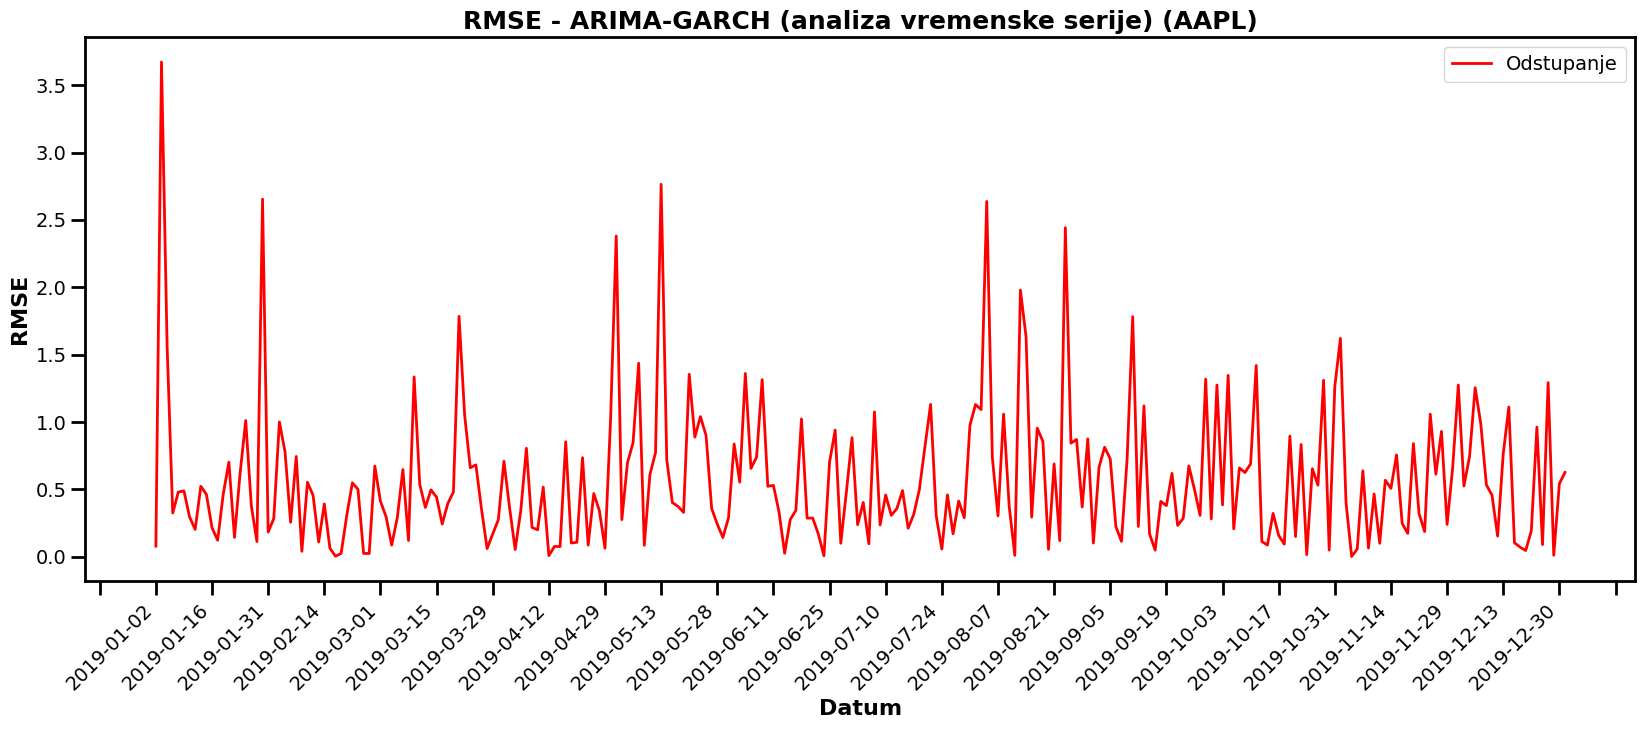

In [6]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot RMSE values with increased line thickness
plt.plot(plot_data["Date"], rmse_values, label='Odstupanje', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('RMSE', fontsize=16, fontweight='bold')
plt.title('RMSE - ARIMA-GARCH (analiza vremenske serije) (AAPL)', fontsize=18, fontweight='bold')

# Customize the legend as requested
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


In [7]:
excel = {
    'Date': plot_data["Date"],
    'RMSE': rmse_values
}
df = pd.DataFrame(excel)

# Export to an Excel file
excel_file_path = 'ARIMA_GARCH_time_series_GOOG_rmse_values.xlsx'
df.to_excel(excel_file_path, index=False)

mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
print(rmse)

0.7821513736416386


In [8]:
excel = {
    'Date': plot_data["Date"],
    'price_diff': predicted_values
}
df = pd.DataFrame(excel)

# Export to an Excel file
excel_file_path = 'ARIMA_GARCH_GOOG_price_diff_values.xlsx'
df.to_excel(excel_file_path, index=False)

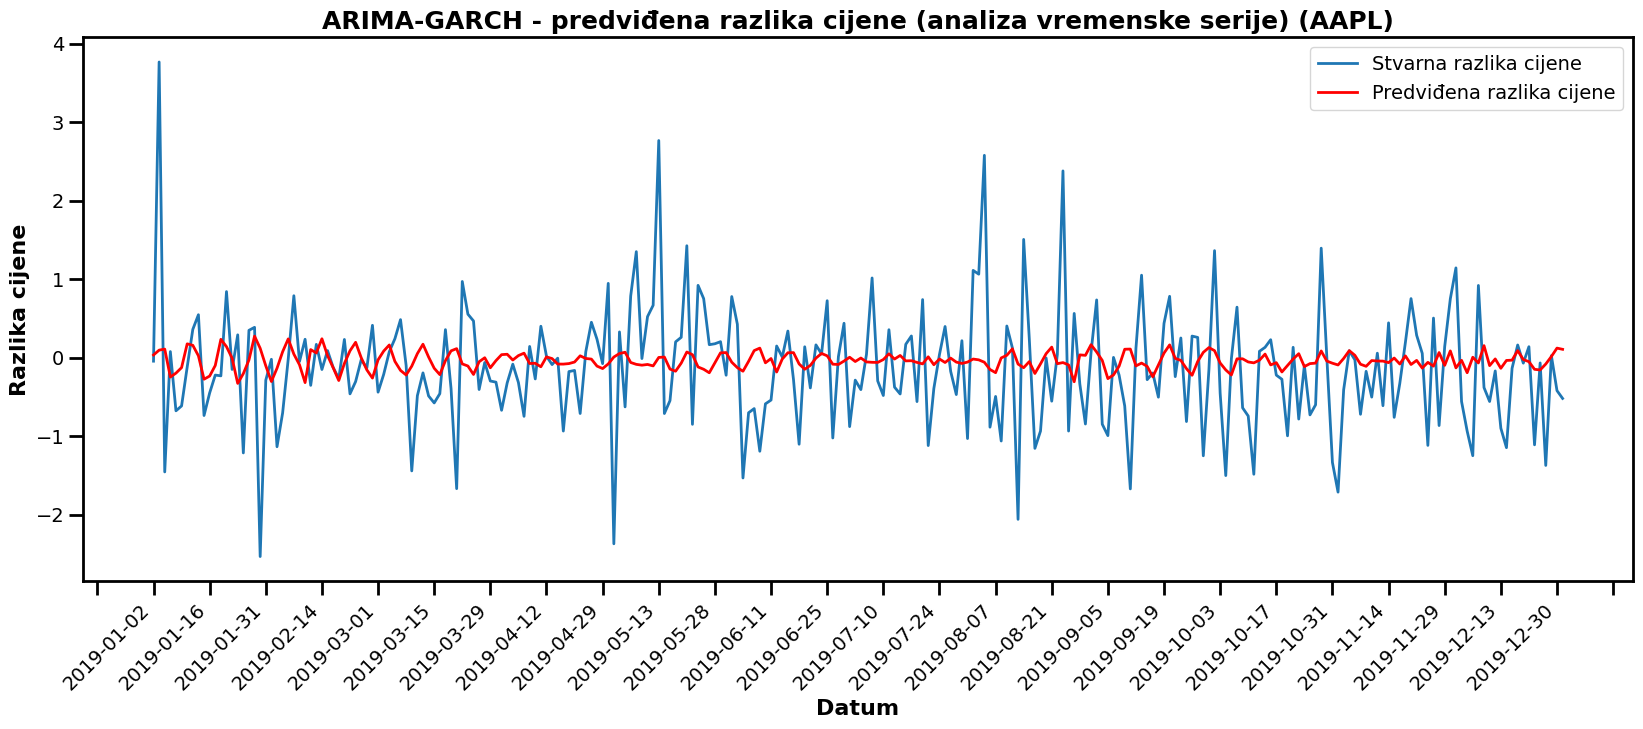

In [9]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot actual and predicted price differences with increased line thickness
plt.plot(plot_data["Date"], actual_values, label='Stvarna razlika cijene', linewidth=2)
plt.plot(plot_data["Date"], predicted_values, label='Predviđena razlika cijene', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Razlika cijene', fontsize=16, fontweight='bold')
plt.title('ARIMA-GARCH - predviđena razlika cijene (analiza vremenske serije) (AAPL)', fontsize=18, fontweight='bold')

# Customize the legend as requested
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


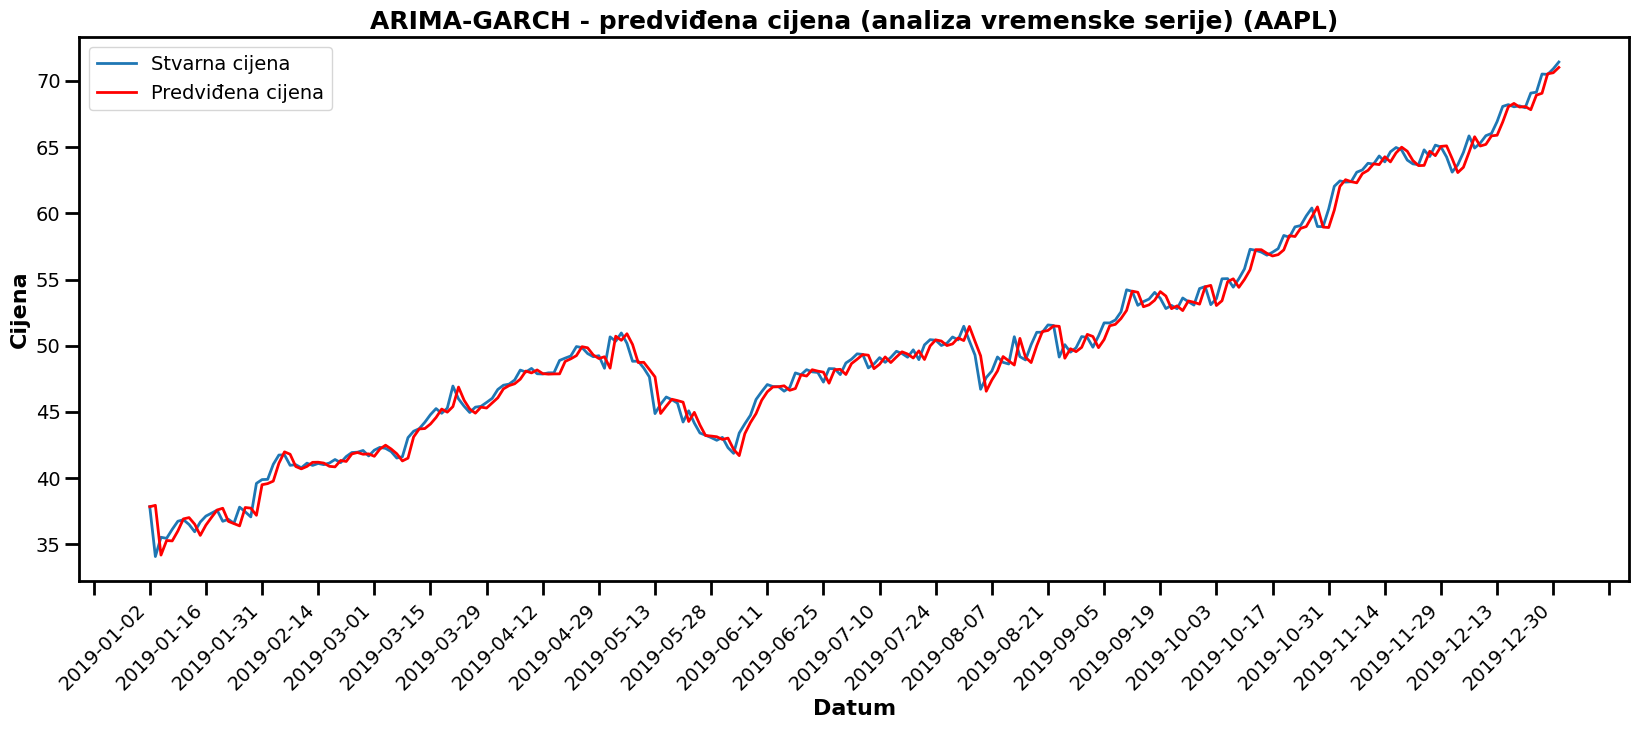

In [10]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plot_data["predicted_diff"] = predicted_values
plot_data["Predicted_price"] = plot_data["yesterday_price"] + plot_data["predicted_diff"]

plt.figure(figsize=(20, 8))

# Plot actual and predicted prices with increased line thickness
plt.plot(plot_data["Date"], plot_data["Adj_Close"], label='Stvarna cijena', linewidth=2)
plt.plot(plot_data["Date"], plot_data["Predicted_price"], label='Predviđena cijena', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Cijena', fontsize=16, fontweight='bold')
plt.title('ARIMA-GARCH - predviđena cijena (analiza vremenske serije) (AAPL)', fontsize=18, fontweight='bold')

# Customize the legend as requested
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()
